In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Data

In [ ]:
os.chdir("/content/drive/My Drive/ECEN758Project")
data = torch.load('./Data/Features/hog_features.pt')
for key, value in data.items():
    print(f'{key.capitalize()} Data (X, y): ', value[0].shape, value[1].shape)

Train Data (X, y):  (55000, 256) (55000,)
Val Data (X, y):  (5000, 256) (5000,)
Test Data (X, y):  (10000, 256) (10000,)


# Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data['train'][0], data['train'][1], test_size = 5000, stratify = data['train'][1], random_state = 10)
data['train'] = [X_train, y_train]
data['val'] = [X_val, y_val]

for key, value in data.items():
    print(f'{key.capitalize()} Data (X, y): ', value[0].shape, value[1].shape)

Train Data (X, y):  (50000, 256) (50000,)
Val Data (X, y):  (5000, 256) (5000,)
Test Data (X, y):  (10000, 256) (10000,)


# Data Transformation

## PCA

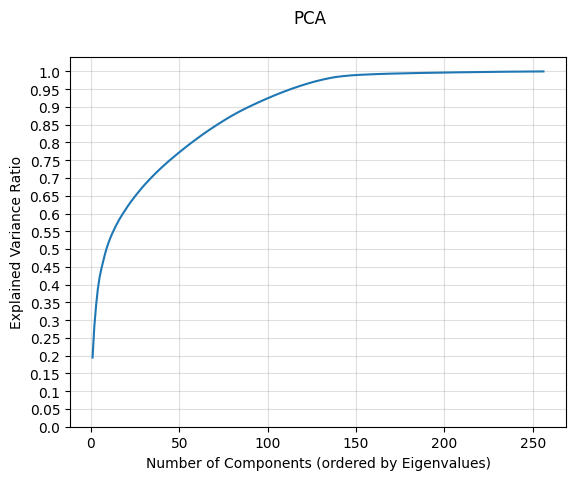

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
scalar = StandardScaler().fit(data['train'][0])
pca.fit(scalar.transform(data['train'][0]))
explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance_ratios)+1), explained_variance_ratios)
plt.xlabel('Number of Components (ordered by Eigenvalues)')
plt.ylabel('Explained Variance Ratio')
plt.suptitle('PCA')
plt.yticks(np.array(range(0, 105, 5))/100, np.array(range(0, 105, 5))/100)
plt.xticks(range(0, len(explained_variance_ratios)+1, 50), range(0, len(explained_variance_ratios)+1, 50))
plt.grid(True, alpha=0.4)
plt.show()

data['train'][0] = pca.transform(scalar.transform(data['train'][0]))
data['val'][0] = pca.transform(scalar.transform(data['val'][0]))
data['test'][0] = pca.transform(scalar.transform(data['test'][0]))

## Normalization

In [ ]:
scalar = StandardScaler().fit(*data['train'])

data['train'][0] = scalar.transform(data['train'][0])
data['val'][0] = scalar.transform(data['val'][0])
data['test'][0] = scalar.transform(data['test'][0])

## Anova Test

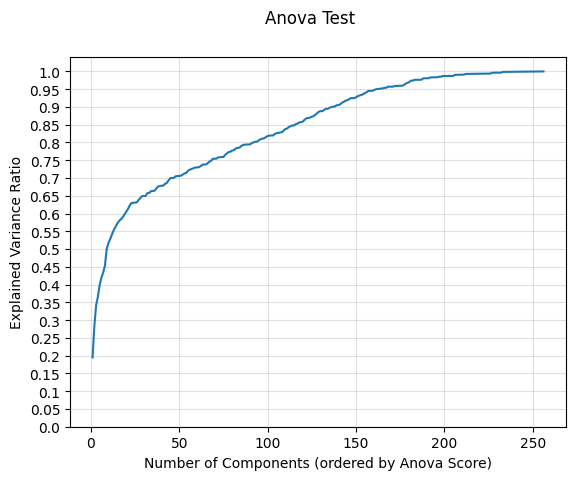

In [ ]:
from sklearn.feature_selection import f_classif

scores, _ = f_classif(*data['train'])

feature_score = list(zip(range(0, data['train'][0].shape[1]), scores))
feature_score = sorted(feature_score, key=lambda item: item[1], reverse=True)

feature_ordering = [item[0] for item in feature_score]

data['train'][0] = data['train'][0][:, feature_ordering]
data['val'][0] = data['val'][0][:, feature_ordering]
data['test'][0] = data['test'][0][:, feature_ordering]

explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_[feature_ordering])

plt.plot(range(1, len(explained_variance_ratios)+1), explained_variance_ratios)
plt.xlabel('Number of Components (ordered by Anova Score)')
plt.ylabel('Explained Variance Ratio')
plt.suptitle('Anova Test')
plt.yticks(np.array(range(0, 105, 5))/100, np.array(range(0, 105, 5))/100)
plt.xticks(range(0, len(explained_variance_ratios)+1, 50), range(0, len(explained_variance_ratios)+1, 50))
plt.grid(True, alpha=0.4)
plt.show()

## Feature Subsets

In [ ]:
min_ev = 0.85
max_ev = 0.98
delta = 0.01

print(f'Component Numbers for an increase in explained variance ratio of {delta} starting from an explained variance ratio of {min_ev} and stopping at an explained variance ratio of {max_ev}')

n_components = []
for n_component, ev in enumerate(explained_variance_ratios):
    if ev>=min_ev and ev<=max_ev:
        n_components.append(n_component+1)
        min_ev += delta

print(n_components)

Component Numbers for an increase in explained variance ratio of 0.01 starting from an explained variance ratio of 0.85 and stopping at an explained variance ratio of 0.98
[116, 121, 124, 128, 132, 137, 142, 146, 151, 156, 162, 177, 181]


# Models

## Gaussian Naive Bayes

Training:


100%|██████████| 13/13 [00:02<00:00,  6.27it/s]


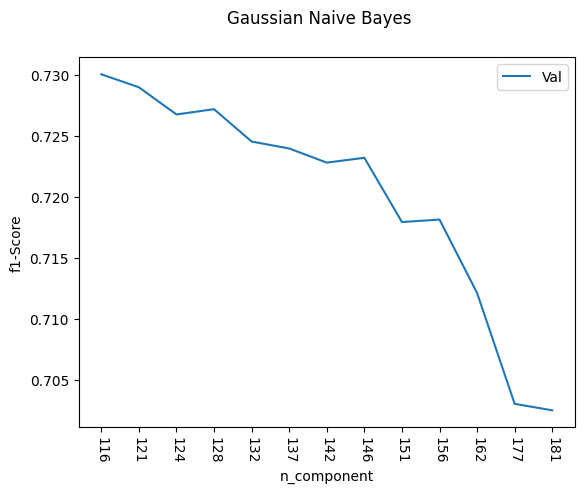

Maximum Validation F1-Score:  0.7300573681157785


In [ ]:
from sklearn.naive_bayes import GaussianNB

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = GaussianNB().fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('Gaussian Naive Bayes')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Nearest Neighbour

Training:


100%|██████████| 13/13 [09:52<00:00, 45.61s/it]


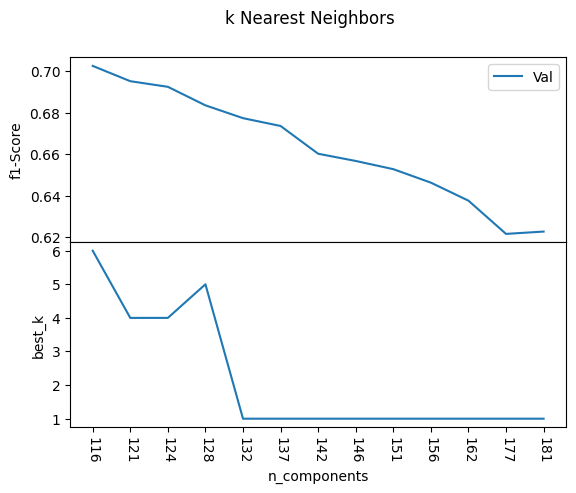

Maximum Validation F1-Score:  0.702486986068083


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

max_k = 10

val_f1_scores = []
best_ks = []

print('Training:')
for n_component in tqdm(n_components):
    k_f1_scores = []
    for k in range(1, max_k+1):

        clf = KNeighborsClassifier(k, n_jobs=-1).fit(data['train'][0][:,:n_component], data['train'][1])

        val_preds = clf.predict(data['val'][0][:,:n_component])

        k_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

    val_f1_scores.append(max(k_f1_scores))
    best_ks.append(k_f1_scores.index(max(k_f1_scores))+1)


fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
ax[0].set_xticks(range(1, len(n_components)+1))
ax[0].set_ylabel('f1-Score')
ax[0].legend()

ax[1].plot(range(1, len(val_f1_scores)+1), best_ks)
ax[1].set_xticks(range(1, len(n_components)+1), n_components, rotation=-90)
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('best_k')
fig.suptitle('k Nearest Neighbors')
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Decision Tree

Training:


100%|██████████| 13/13 [06:12<00:00, 28.68s/it]


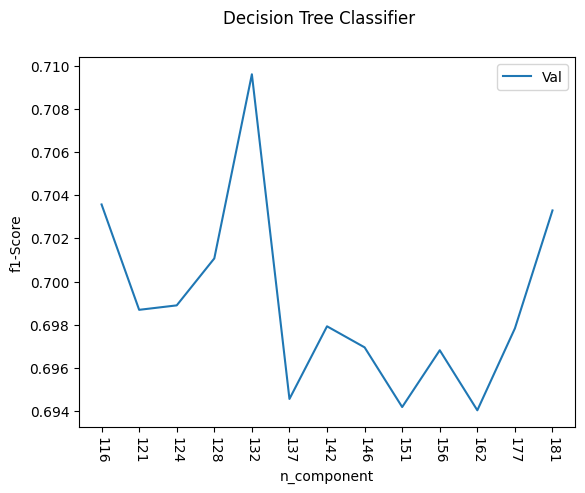

Maximum Validation F1-Score:  0.7095962627363599


In [ ]:
from sklearn.tree import DecisionTreeClassifier

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = DecisionTreeClassifier().fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('Decision Tree Classifier')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Random Forest

Training:


100%|██████████| 13/13 [12:42<00:00, 58.66s/it]


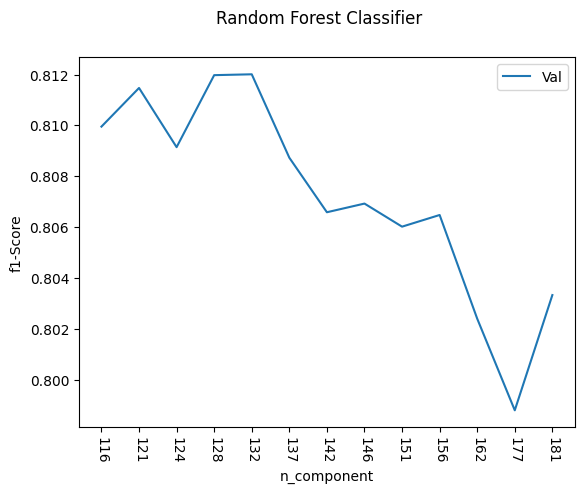

Maximum Validation F1-Score:  0.8120087977731876


In [ ]:
from sklearn.ensemble import RandomForestClassifier

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = RandomForestClassifier(n_jobs=-1).fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('Random Forest Classifier')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Logistic Regression

Training:


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 1/13 [02:58<35:37, 178.08s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 2/13 [06:03<33:25, 182.31s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 3/13 [09:10<30:45, 184.51s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 4/13 [12:27<28:23, 189.26s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: 

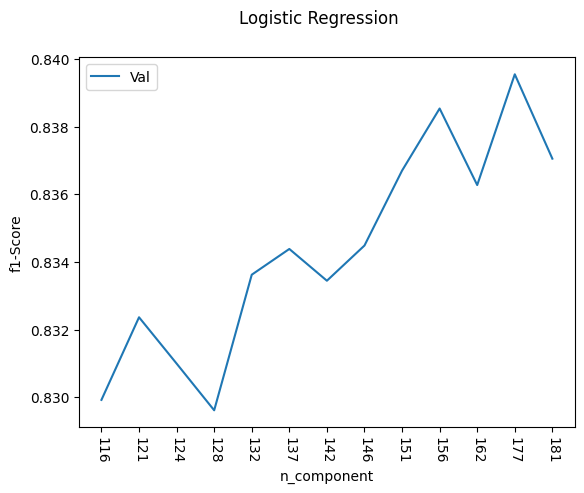

Maximum Validation F1-Score:  0.8395469860971942


In [ ]:
from sklearn.linear_model import LogisticRegression

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = LogisticRegression(solver='saga', n_jobs=-1, max_iter=500).fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('Logistic Regression')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## SVM

Training:


100%|██████████| 13/13 [33:25<00:00, 154.29s/it]


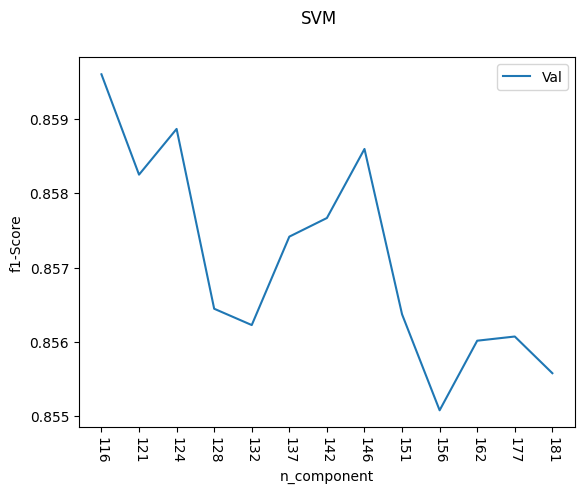

Maximum Validation F1-Score:  0.8595953807528891


In [ ]:
from sklearn.svm import SVC

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = SVC().fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('SVM')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Feed Forward Network

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class fmnist_vit_features_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, index):
        X = self.data[0][index]
        y = torch.zeros(size =(10,))
        y[int(self.data[1][index])] = 1
        return torch.tensor(X), y


data = torch.load('./Data/Features/hog_features.pt')

X_train, X_val, y_train, y_val = train_test_split(data['train'][0], data['train'][1], test_size = 5000, stratify = data['train'][1], random_state = 10)
data['train'] = [X_train, y_train]
data['val'] = [X_val, y_val]

train_loader = DataLoader(fmnist_vit_features_dataset(data['train']), batch_size= 512, num_workers=10)
val_loader = DataLoader(fmnist_vit_features_dataset(data['val']), batch_size= 512, num_workers=10)
test_loader = DataLoader(fmnist_vit_features_dataset(data['test']), batch_size= 512, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torch import nn

class FeedForwardNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 10),
            nn.Softmax(dim=-1)
        )
    def forward(self, X):
        outs = self.linear(X)
        return outs

device = ("cuda" if torch.cuda.is_available() else "cpu")

model = FeedForwardNetwork(data['train'][0].shape[1]).to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

num_epochs = 30

FeedForwardNetwork(
  (linear): Sequential(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
    (2): Softmax(dim=-1)
  )
)


In [ ]:
train_loss = []
train_f1_scores = []

val_loss = []
val_f1_scores = []

print('Training:')
for epoch in tqdm(range(0, num_epochs)):
    running_preds = []
    running_labels = []
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            running_preds.append(pred)
            running_labels.append(y)

    preds, labels = torch.vstack(running_preds), torch.vstack(running_labels)
    train_loss.append(loss_fn(preds, labels).item())
    train_f1_scores.append(f1_score(labels.argmax(-1).cpu(), preds.argmax(-1).cpu(), average='macro'))

    with torch.no_grad():
        running_preds = []
        running_labels = []
        for batch, (X,y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            running_preds.append(pred)
            running_labels.append(y)

        preds, labels = torch.vstack(running_preds), torch.vstack(running_labels)
        val_loss.append(loss_fn(preds, labels).item())
        val_f1_scores.append(f1_score(labels.argmax(-1).cpu(), preds.argmax(-1).cpu(), average='macro'))

print('Maximum Validation F1-Score: ', max(val_f1_scores))

Training:


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  3%|▎    

Maximum Validation F1-Score:  0.8348375374859411


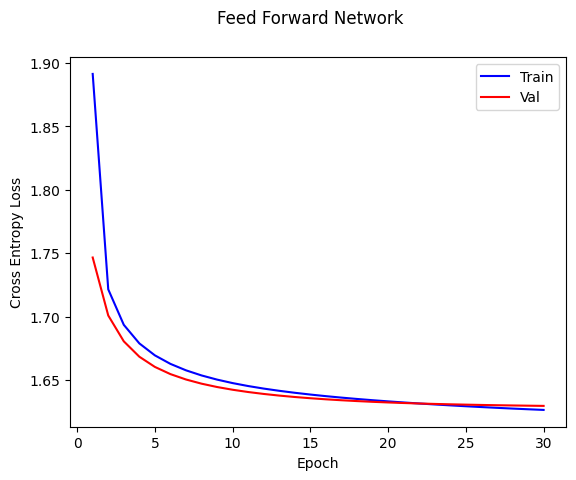

In [ ]:
plt.plot(range(1, len(train_loss)+1), train_loss, label = 'Train', c='blue')
plt.plot(range(1, len(val_loss)+1), val_loss, label = 'Val', c='red')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.suptitle('Feed Forward Network')
plt.legend()
plt.show()

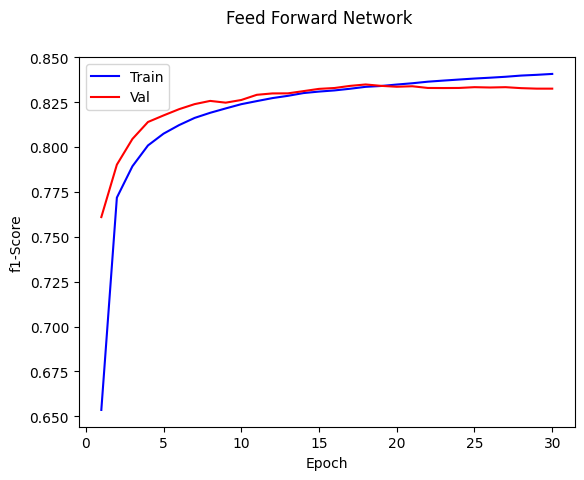

In [ ]:
plt.plot(range(1, len(train_f1_scores)+1), train_f1_scores, label = 'Train', c='blue')
plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val', c='red')
plt.xlabel('Epoch')
plt.ylabel('f1-Score')
plt.suptitle('Feed Forward Network')
plt.legend()
plt.show()